Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [32]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [13]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [20]:
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  tar.extractall()
  tar.close()
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_folders, len(data_folders)))
  print data_folders
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [33]:
from IPython.display import display, Image
from io import BytesIO

for c in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']:
    my_image = Image('notMNIST_small/'+c+'/SGVsZW5hLUJvbGQudHRm.png')
    display(my_image)
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w))
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


if __name__ == '__main__':
    hinton(np.random.rand(20, 20) - 0.5)
    plt.show()

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [21]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

notMNIST_large/A
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 

 notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 

 notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 


Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 


Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H
notMNIST_large/I
notMNIST_large/J
Full dataset tensor: (529114, 28, 28)
Mean: -0.0816596
Standard deviation: 

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 

0.454233
Labels: (529114,)
notMNIST_small/A
Could not read: notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
notMNIST_small/B
notMNIST_small/C
notMNIST_small/D
notMNIST_small/E
notMNIST_small/F

ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/IptcImagePlugin.py", line 113, in _open
    layers = i8(self.info[(3, 60)][0])
KeyError: (3, 60)
ERROR:PIL.ImageFile:%s
Traceback (most recent call last):
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/ImageFile.py", line 100, in __init__
    self._open()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 71, in _open
    if s.read(32) != 0x1B3:
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 53, in read
    v = self.peek(bits)
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 38, in peek
    c = self.next()
  File "/Users/atulkumar/anaconda/lib/python2.7/site-packages/PIL/MpegImagePlugin.py", line 34, 


Could not read: notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
notMNIST_small/G
notMNIST_small/H
notMNIST_small/I
notMNIST_small/J
Full dataset tensor: (18724, 28, 28)
Mean: -0.0746362
Standard deviation: 0.458622
Labels: (18724,)


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

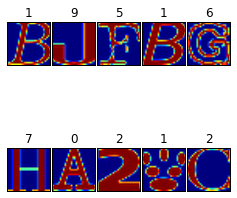

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(4, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
  
for i in range(10):
    axes.flat[i].imshow(train_dataset[i])
    axes.flat[i].set_title(train_labels[i])
    

plt.show()


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [22]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

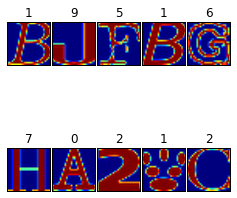

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(4, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)
  
    
for i in range(10):
    axes.flat[i].imshow(train_dataset[i])
    axes.flat[i].set_title(train_labels[i])
    
plt.show()


---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [43]:
y = np.bincount(train_labels)
ii = np.nonzero(y)[0]
print np.vstack((ii,y[ii])).T

y = np.bincount(test_labels)
ii = np.nonzero(y)[0]
print np.vstack((ii,y[ii])).T

[[    0 20066]
 [    1 19720]
 [    2 20107]
 [    3 19904]
 [    4 20094]
 [    5 20044]
 [    6 20157]
 [    7 20036]
 [    8 19910]
 [    9 19962]]
[[   0 1872]
 [   1 1873]
 [   2 1873]
 [   3 1873]
 [   4 1873]
 [   5 1872]
 [   6 1872]
 [   7 1872]
 [   8 1872]
 [   9 1872]]


Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [44]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (190000, 28, 28) (190000,)
Validation (10000, 28, 28) (10000,)


Finally, let's save the data for later reuse:

In [45]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [46]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 686793801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [130]:
def dhash(image, hash_size = 16):
        # Compare adjacent pixels.
        difference = []
        for row in xrange(hash_size):
            for col in xrange(hash_size):
                pixel_left = image[col][row]
                pixel_right = image[col + 1][row]
                difference.append(pixel_left > pixel_right)

        # Convert the binary array to a hexadecimal string.
        decimal_value = 0
        hex_string = []
        for index, value in enumerate(difference):
            if value:
                decimal_value += 2**(index % 8)
            if (index % 8) == 7:
                hex_string.append(hex(decimal_value)[2:].rjust(2, '0'))
                decimal_value = 0

        return ''.join(hex_string)

In [146]:
import hashlib
from collections import defaultdict
train_hash = defaultdict(set)
test_hash = defaultdict(set)
valid_hash = defaultdict(set)

for i in range(train_dataset.shape[0]):
    train_hash[hashlib.md5(train_dataset[i].reshape(-1,1)).hexdigest()].add(i)

for i in range(test_dataset.shape[0]):
    test_hash[hashlib.md5(test_dataset[i].reshape(-1,1)).hexdigest()].add(i)
    
for i in range(valid_dataset.shape[0]):
    valid_hash[hashlib.md5(valid_dataset[i].reshape(-1,1)).hexdigest()].add(i)
 

In [148]:
matching = set(train_hash.iterkeys()).intersection(set(test_hash.iterkeys()))

test_delete = set()
for m in matching:
    test_delete |= test_hash[m]


matching_v = set(train_hash.iterkeys()).intersection(set(valid_hash.iterkeys()))

valid_delete = set()
for m in matching_v:
    valid_delete |= valid_hash[m]

    

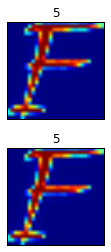

In [142]:
fig, axes = plt.subplots(2, 1, figsize=(4, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

axes.flat[0].imshow(train_dataset[3757])
axes.flat[0].set_title(train_labels[3757])
axes.flat[1].imshow(test_dataset[11141])
axes.flat[1].set_title(test_labels[11141])
    
plt.show()

In [77]:
from skimage.measure import structural_similarity as ssim

def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

to_delete_valid =[]
for i in range(train_dataset.shape[0]):
    for j in range(valid_dataset.shape[0]):
        if train_labels[i] == valid_labels[j]:
            to_delete = to_delete + [j]
            ssim_Score = ssim(train_dataset[i], valid_dataset[j])
            if ssim_Score > 0.9:
                #print 'train_dataset', i, 'valid_dataset', j,ssim_Score 
                to_delete_valid = to_delete_valid + [j]


KeyboardInterrupt: 

In [ ]:
to_delete_test =[]
for i in range(train_dataset.shape[0]):
    for j in range(test_dataset.shape[0]):
        if train_labels[i] == test_labels[j]:
            ssim_Score = ssim(train_dataset[i], test_dataset[j])
            
            if ssim_Score > 0.9:
                #print 'train_dataset', i, 'valid_dataset', j,ssim_Score 
                to_delete_test = to_delete_test + [j]

In [152]:
valid_dataset = np.delete(valid_dataset, list(valid_delete), 0)
valid_labels = np.delete(valid_labels, list(valid_delete), 0)

test_dataset = np.delete(test_dataset, list(test_delete), 0)
test_labels = np.delete(test_labels, list(test_delete), 0)


In [153]:
pickle_file = 'notMNIST1.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [154]:
pickle_file = 'notMNIST1.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print 'Training set', train_dataset.shape, train_labels.shape
  print 'Validation set', valid_dataset.shape, valid_labels.shape
  print 'Test set', test_dataset.shape, test_labels.shape

Training set (190000, 28, 28) (190000,)
Validation set (8946, 28, 28) (8946,)
Test set (16430, 28, 28) (16430,)


In [155]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset1, train_labels1 = reformat(train_dataset, train_labels)
valid_dataset1, valid_labels1 = reformat(valid_dataset, valid_labels)
test_dataset1, test_labels1 = reformat(test_dataset, test_labels)
print 'Training set', train_dataset1.shape, train_labels1.shape
print 'Validation set', valid_dataset1.shape, valid_labels1.shape
print 'Test set', test_dataset1.shape, test_labels1.shape

Training set (190000, 784) (190000, 10)
Validation set (8946, 784) (8946, 10)
Test set (16430, 784) (16430, 10)


In [161]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [157]:
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import log_loss

clf = LogisticRegression()
X = train_dataset1[:5000, :]
y = train_labels[:5000]
X_test = test_dataset1
y_test = test_labels1
clf.fit(X, y) 
y_pred = clf.predict_proba(X_test)
print 'accuracy: %f' % ( accuracy(y_test, y_pred) )

accuracy: 0.701436


In [158]:
clf = LogisticRegression()
X = train_dataset1[:50, :]
y = train_labels[:50]
X_test = test_dataset1
y_test = test_labels1
clf.fit(X, y) 
y_pred = clf.predict_proba(X_test)
print 'accuracy: %f' % ( log_loss(y_test, y_pred) )

accuracy: 1.257258


In [159]:
clf = LogisticRegression()
X = train_dataset1[:100, :]
y = train_labels[:100]
X_test = test_dataset1
y_test = test_labels1
clf.fit(X, y) 
y_pred = clf.predict_proba(X_test)
print 'accuracy: %f' % ( log_loss(y_test, y_pred) )

accuracy: 0.995770


In [160]:
clf = LogisticRegression()
X = train_dataset1[:1000, :]
y = train_labels[:1000]
X_test = test_dataset1
y_test = test_labels1
clf.fit(X, y) 
y_pred = clf.predict_proba(X_test)
print 'accuracy: %f' % ( log_loss(y_test, y_pred) )

accuracy: 0.765801
